In [2]:
repo_root = "/Users/miskodzamba/Dropbox/research/gits/spf/"
import sys

if repo_root not in sys.path:
    sys.path.append(repo_root)  # go to parent dir

In [4]:
import os
from spf.sdrpluto.sdr_controller import (
    get_segmentation_for_zarr,
    segment_session_star,
)
from multiprocessing import Pool
import time
import tqdm
import pickle

root = "/Volumes/SPFData/missions/april5"

zarr_fns = [
    root + "/" + x
    for x in [
        "wallarrayv3_2024_04_03_04_51_55_nRX2_bounce.zarr",
        "wallarrayv3_2024_04_03_16_49_58_nRX2_rx_circle.zarr",
        "wallarrayv3_2024_04_03_23_54_35_nRX2_bounce.zarr",
        "wallarrayv3_2024_04_04_17_10_05_nRX2_rx_circle.zarr",
        "wallarrayv3_2024_04_05_00_14_15_nRX2_bounce.zarr",
        "wallarrayv3_2024_04_05_22_13_07_nRX2_rx_circle.zarr",
        "wallarrayv3_2024_04_06_05_15_04_nRX2_bounce.zarr",
    ]
]


for zarr_fn in zarr_fns:
    get_segmentation_for_zarr(zarr_fn)

In [5]:
import yaml
from spf.dataset.spf_dataset import pi_norm
from spf.sdrpluto.sdr_controller import phase_diff_to_theta
from spf.utils import zarr_open_from_lmdb_store_cm
import numpy as np

from spf.rf import c as speed_of_light


def get_expected_theta(zarr_fn, rx_idx):
    with zarr_open_from_lmdb_store_cm(zarr_fn) as z:
        tx_pos = np.vstack(
            [
                z.receivers.r0.tx_pos_x_mm,
                z.receivers.r0.tx_pos_y_mm,
            ]
        ).T
        rx_pos = np.array(
            [
                z.receivers.r0.rx_pos_x_mm,
                z.receivers.r0.rx_pos_y_mm,
            ]
        ).T
        d = tx_pos - rx_pos
        rx_to_tx_theta = np.arctan2(d[:, 0], d[:, 1])
        return pi_norm(
            rx_to_tx_theta - z.receivers[f"r{rx_idx}"].rx_theta_in_pis[:] * np.pi
        )


def segmentation_to_chunk_stats(results_by_receiver):
    chunk_stats = {}
    for receiver, results in results_by_receiver.items():
        chunk_stats[receiver] = {
            "mean": np.array(
                [np.array([x["mean"] for x in result]).mean() for result in results]
            ),
            "std": np.array(
                [np.array([x["stddev"] for x in result]).std() for result in results]
            ),
        }
    return chunk_stats


def get_estimated_theta(zarr_fn, rx_idx):
    with zarr_open_from_lmdb_store_cm(zarr_fn) as z:
        if "rx_lo" not in z.receivers[f"r{rx_idx}"]:
            # back off to YAML CONFIG
            yaml_config = yaml_config = yaml.safe_load(
                open(zarr_fn.replace(".zarr", ".yaml"), "r")
            )
            carrier_freq = yaml_config["receivers"][rx_idx]["f-carrier"]
            antenna_spacing = yaml_config["receivers"][rx_idx]["antenna-spacing-m"]
        else:
            carrier_freq = z.receivers[f"r{rx_idx}"].rx_lo
            carrier_freq = z.receivers[f"r{rx_idx}"].rx_lo

    chunk_stats = segmentation_to_chunk_stats(get_segmentation_for_zarr(zarr_fn))
    estimated_thetas_by_rx = {}
    for rx_idx in [0, 1]:
        estimated_thetas_by_rx[f"r{rx_idx}"] = {
            "mean": phase_diff_to_theta(
                chunk_stats[f"r{rx_idx}"]["mean"],
                speed_of_light / carrier_freq,
                antenna_spacing,
                large_phase_goes_right=False,
            ),
            "noise": np.nanmean(chunk_stats[f"r{rx_idx}"]["std"]),
        }
    return estimated_thetas_by_rx

In [6]:
# get_segmentation_for_zarr(zarr_fn)

In [7]:
from spf.sdrpluto.sdr_controller import circular_diff_to_mean


error_in_estimation_by_receiver_and_angle_agg = {}
error_in_estimation_by_receiver_angle_pairs = {}

angle_resolution = 128


def theta_to_bin(theta, angle_resolution):
    zero_to_one_normed = (pi_norm(theta) / np.pi + 1) / 2
    return np.rint(zero_to_one_normed * angle_resolution)


def bin_to_theta(bin, angle_resolution):
    return ((bin / angle_resolution) * 2 - 1) * np.pi


for rx_idx in [0, 1]:
    error_in_estimation_by_receiver_angle_pairs[f"r{rx_idx}"] = []
    estimated_angles_by_bin_dict = {idx: [] for idx in range(angle_resolution)}
    estimated_noise_by_bin_dict = {idx: [] for idx in range(angle_resolution)}
    for zarr_fn in zarr_fns:
        expected_theta = get_expected_theta(zarr_fn, rx_idx)
        theta_bins = theta_to_bin(expected_theta, angle_resolution=angle_resolution)

        estimated_thetas = get_estimated_theta(zarr_fn, rx_idx)

        diff_to_estimated_values = np.array(
            [
                circular_diff_to_mean(
                    expected_theta, estimated_thetas[f"r{rx_idx}"]["mean"][0]
                ),
                circular_diff_to_mean(
                    expected_theta, estimated_thetas[f"r{rx_idx}"]["mean"][1]
                ),
            ]
        ).min(axis=0)

        error_in_estimation_by_receiver_angle_pairs[f"r{rx_idx}"] += [
            (actual, diff)
            for actual, diff in zip(
                expected_theta,
                diff_to_estimated_values,
            )
        ]

        for idx in range(theta_bins.shape[0]):
            if np.isfinite(diff_to_estimated_values[idx]):
                bin = theta_bins[idx]
                assert 0 <= bin and bin <= angle_resolution
                bin = bin % angle_resolution
                estimated_angles_by_bin_dict[bin].append(diff_to_estimated_values[idx])
                estimated_noise_by_bin_dict[bin].append(
                    estimated_thetas[f"r{rx_idx}"]["noise"].mean()
                )

    means_by_bin = np.zeros(angle_resolution)
    stddevs_by_bin = np.zeros(angle_resolution)
    noise_by_bin = np.zeros(angle_resolution)
    total_samples = 0
    for bin in range(angle_resolution):
        total_samples += len(estimated_angles_by_bin_dict[bin])
        means_by_bin[bin] = np.array(estimated_angles_by_bin_dict[bin]).mean()
        stddevs_by_bin[bin] = np.array(estimated_angles_by_bin_dict[bin]).std()
        noise_by_bin[bin] = np.array(estimated_noise_by_bin_dict[bin]).mean()
    # print(total_samples)
    error_in_estimation_by_receiver_and_angle_agg[f"r{rx_idx}"] = {
        "mean": means_by_bin,
        "std": stddevs_by_bin,
        "noise": noise_by_bin,
    }
    error_in_estimation_by_receiver_angle_pairs[f"r{rx_idx}"] = np.array(
        error_in_estimation_by_receiver_angle_pairs[f"r{rx_idx}"]
    )

/var/folders/31/j84vsqkx1rg7zggf_0glkq8m0000gn/T/ipykernel_2390/1006524412.py:36: RuntimeWarning: Mean of empty slice.
  [np.array([x["mean"] for x in result]).mean() for result in results]
/Users/miskodzamba/.virtualenvs/spf/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/miskodzamba/.virtualenvs/spf/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/miskodzamba/.virtualenvs/spf/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/miskodzamba/.virtualenvs/spf/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/31/j84vsqkx1rg7zg

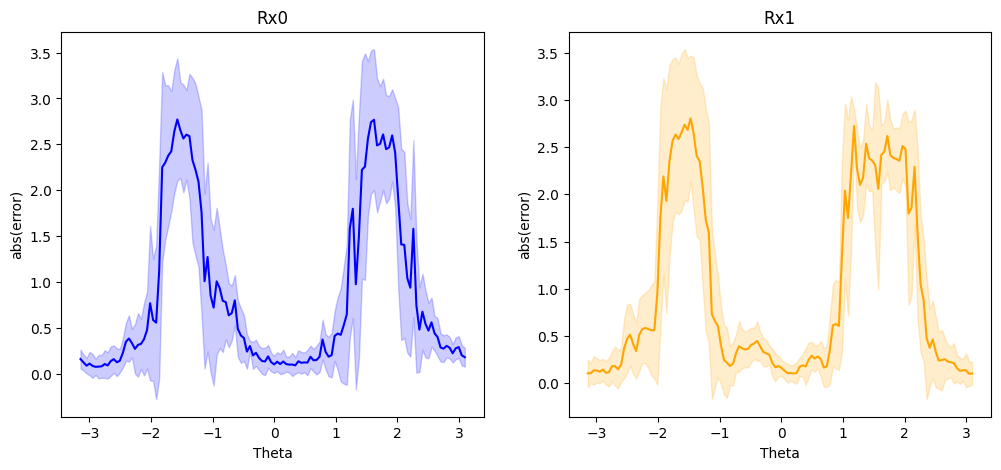

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
colors = ["blue", "orange"]
for rx_idx in [0, 1]:
    stats = error_in_estimation_by_receiver_and_angle_agg[f"r{rx_idx}"]
    axs[rx_idx].fill_between(
        x=bin_to_theta(np.arange(angle_resolution), angle_resolution),
        y1=stats["mean"] - stats["std"],
        y2=stats["mean"] + stats["std"],
        alpha=0.2,
        color=colors[rx_idx],
    )
    axs[rx_idx].plot(
        bin_to_theta(np.arange(angle_resolution), angle_resolution),
        stats["mean"],
        color=colors[rx_idx],
    )
    # axs[rx_idx].plot(
    #     bin_to_theta(np.arange(angle_resolution), angle_resolution),
    #     stats["noise"],
    #     color=colors[rx_idx],
    # )
    axs[rx_idx].set_title(f"Rx{rx_idx}")
    axs[rx_idx].set_xlabel("Theta")
    axs[rx_idx].set_ylabel("abs(error)")

In [9]:
# stats["noise"]

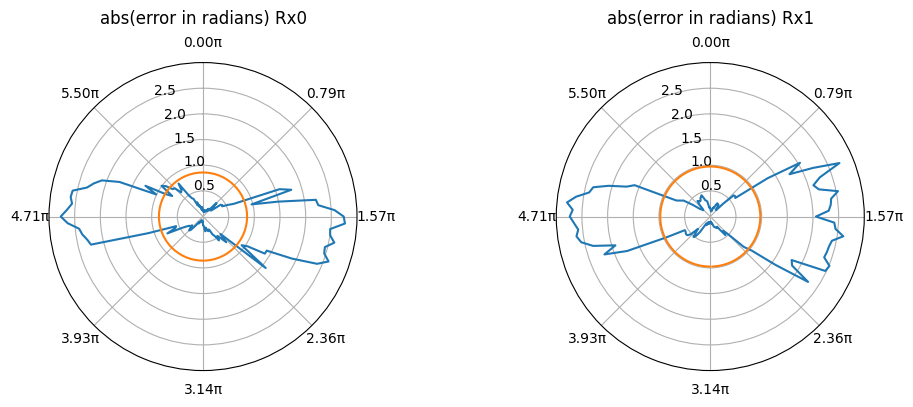

In [10]:
from matplotlib.ticker import FuncFormatter

r = np.arange(0, 2, 0.01)
theta = 2 * np.pi * r

fig, axs = plt.subplots(1, 2, figsize=(12, 4), subplot_kw={"projection": "polar"})
for rx_idx in [0, 1]:

    stats = error_in_estimation_by_receiver_and_angle_agg[f"r{rx_idx}"]
    axs[rx_idx].plot(
        bin_to_theta(np.arange(angle_resolution), angle_resolution), stats["mean"]
    )
    axs[rx_idx].plot(
        bin_to_theta(np.arange(angle_resolution), angle_resolution),
        stats["mean"] * 0 + stats["mean"].mean(),
    )
    axs[rx_idx].set_rmax(3)
    axs[rx_idx].set_rticks([0.5, 1, 1.5, 2, 2.5])  # Less radial ticks
    axs[rx_idx].set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    axs[rx_idx].grid(True)

    axs[rx_idx].set_theta_zero_location("N", 0)
    axs[rx_idx].set_theta_direction(-1)

    axs[rx_idx].set_title(f"abs(error in radians) Rx{rx_idx}", va="bottom")
    rad2fmt = lambda x, pos: f"{np.rad2deg(x):.2f}°"
    rad2fmt = lambda x, pos: f"{x:.2f}π"
    axs[rx_idx].xaxis.set_major_formatter(FuncFormatter(rad2fmt))
# plt.show()

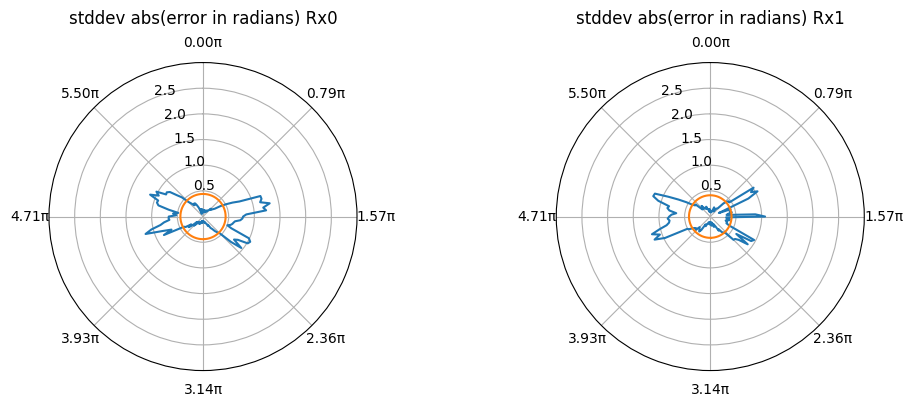

In [11]:
from matplotlib.ticker import FuncFormatter

r = np.arange(0, 2, 0.01)
theta = 2 * np.pi * r

fig, axs = plt.subplots(1, 2, figsize=(12, 4), subplot_kw={"projection": "polar"})
for rx_idx in [0, 1]:

    stats = error_in_estimation_by_receiver_and_angle_agg[f"r{rx_idx}"]
    axs[rx_idx].plot(
        bin_to_theta(np.arange(angle_resolution), angle_resolution), stats["std"]
    )
    axs[rx_idx].plot(
        bin_to_theta(np.arange(angle_resolution), angle_resolution),
        stats["std"] * 0 + stats["std"].mean(),
    )
    axs[rx_idx].set_rmax(3)
    axs[rx_idx].set_rticks([0.5, 1, 1.5, 2, 2.5])  # Less radial ticks
    axs[rx_idx].set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    axs[rx_idx].grid(True)

    axs[rx_idx].set_theta_zero_location("N", 0)
    axs[rx_idx].set_theta_direction(-1)

    axs[rx_idx].set_title(f"stddev abs(error in radians) Rx{rx_idx}", va="bottom")
    rad2fmt = lambda x, pos: f"{np.rad2deg(x):.2f}°"
    rad2fmt = lambda x, pos: f"{x:.2f}π"
    axs[rx_idx].xaxis.set_major_formatter(FuncFormatter(rad2fmt))
# plt.show()

In [20]:
z = error_in_estimation_by_receiver_angle_pairs["r0"][:, 1]
np.nanmax(z)

3.141376799780671

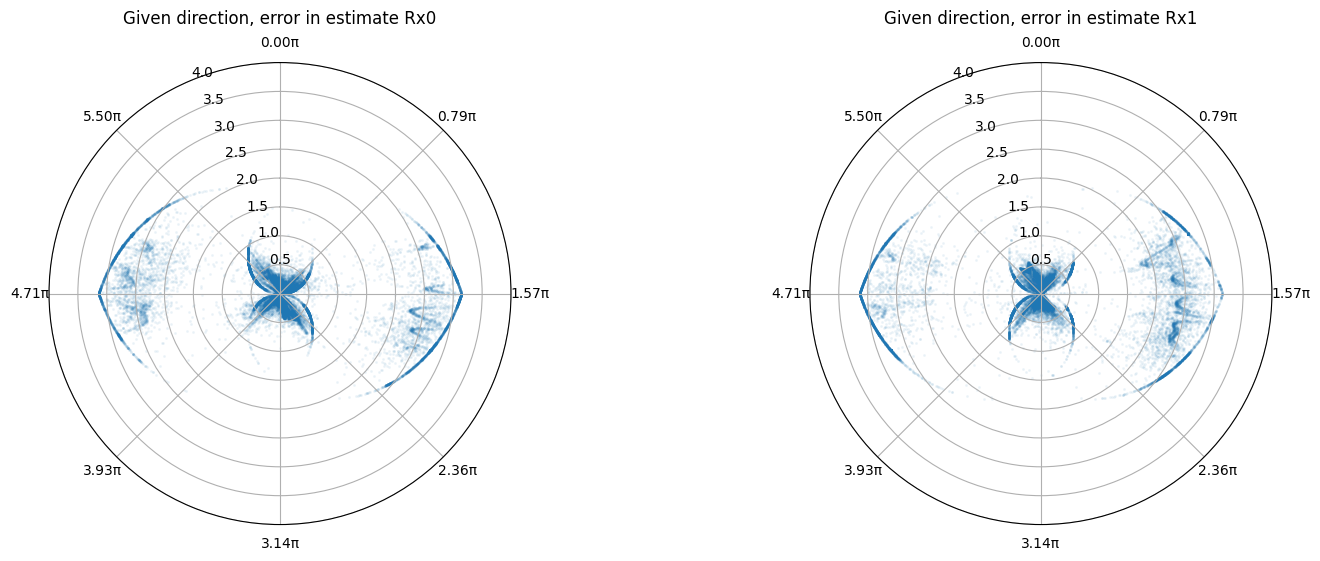

In [12]:
from matplotlib.ticker import FuncFormatter

r = np.arange(0, 2, 0.01)
theta = 2 * np.pi * r

fig, axs = plt.subplots(1, 2, figsize=(18, 6), subplot_kw={"projection": "polar"})
for rx_idx in [0, 1]:

    stats = error_in_estimation_by_receiver_and_angle_agg[f"r{rx_idx}"]
    axs[rx_idx].scatter(
        error_in_estimation_by_receiver_angle_pairs[f"r{rx_idx}"][:, 0],
        error_in_estimation_by_receiver_angle_pairs[f"r{rx_idx}"][:, 1],
        alpha=0.05,
        s=1.5,
    )
    axs[rx_idx].set_rmax(4)
    axs[rx_idx].set_rticks([0.5, 1, 1.5, 2, 2.5, 3.0, 3.5, 4.0])  # Less radial ticks
    axs[rx_idx].set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    axs[rx_idx].grid(True)

    axs[rx_idx].set_theta_zero_location("N", 0)
    axs[rx_idx].set_theta_direction(-1)

    axs[rx_idx].set_title(f"Given direction, error in estimate Rx{rx_idx}", va="bottom")
    rad2fmt = lambda x, pos: f"{np.rad2deg(x):.2f}°"
    rad2fmt = lambda x, pos: f"{x:.2f}π"
    axs[rx_idx].xaxis.set_major_formatter(FuncFormatter(rad2fmt))
# plt.show()

/var/folders/31/j84vsqkx1rg7zggf_0glkq8m0000gn/T/ipykernel_2390/1034419629.py:27: RuntimeWarning: invalid value encountered in arcsin
  v = np.arcsin(l * phi / (d * 2 * np.pi))


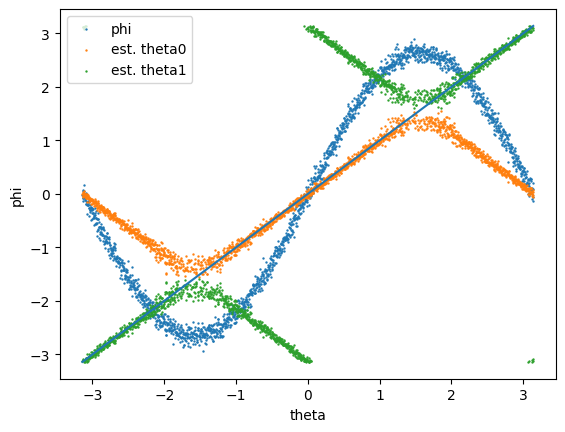

In [29]:
thetas = np.linspace(-np.pi, np.pi, 128 * 16)

d = 0.0505  # seperation
l = 0.12  # lambda

"""
theta is the angle from array normal to incident
phi is phase difference

delta_distance  = d*sin(theta)
phi = delta_distance * 2pi / lambda = sin(theta)*d*2pi/lambda
theta = arcsin(lambda * phi / (d*2pi))
"""


def theta_to_phi(theta):
    return np.sin(theta) * d * 2 * np.pi / l


def phi_to_theta(phi, limit=False):
    sin_arg = l * phi / (d * 2 * np.pi)
    # assert sin_arg.min()>-1
    # assert sin_arg.max()<1
    if limit:
        edge = 1 - 1e-8
        sin_arg = np.clip(sin_arg, a_min=-edge, a_max=edge)
    v = np.arcsin(l * phi / (d * 2 * np.pi))
    return v, np.pi - v


phis = theta_to_phi(thetas)
phis += np.random.randn(phis.shape[0]) * 0.1
phis = pi_norm(phis)
_thetas = phi_to_theta(phis, limit=True)

plt.scatter(thetas, phis, s=0.5, label="phi")
plt.scatter(thetas, pi_norm(_thetas[0]), s=0.5, label="est. theta0")
plt.scatter(thetas, pi_norm(_thetas[1]), s=0.5, label="est. theta1")
plt.xlabel("theta")
plt.ylabel("phi")
plt.legend()
plt.plot(thetas, thetas)

In [ ]:
from spf.sdrpluto.sdr_controller import simple_segment


rng = np.random.default_rng(12345)
fake_signal = rng.standard_normal(600)

ground_truth_windows = [
    {"start_idx": 0, "end_idx": 100, "mean": 0.5},
    {"start_idx": 300, "end_idx": 400, "mean": 1.3},
    {"start_idx": 500, "end_idx": 600, "mean": 1.25},
]

for window in ground_truth_windows:
    fake_signal[window["start_idx"] : window["end_idx"]] /= 10
    fake_signal[window["start_idx"] : window["end_idx"]] += window["mean"]

mean_diff_threshold = 0.05
segmented_windows = simple_segment(
    fake_signal,
    window_size=100,
    stride=50,
    trim=10,
    mean_diff_threshold=mean_diff_threshold,
    max_stddev_threshold=0.1,
)

NameError: name 'np' is not defined

In [ ]:
segmented_windows[0]

{'start_idx': 0,
 'end_idx': 100,
 'mean': 0.4956574168449164,
 'stddev': 0.077522671566404}

In [128]:
fake_signal

array([ 0.3576175 ,  0.62637285,  0.41293383,  0.47408268,  0.49246567,
        0.42591153,  0.36322073,  0.56488928,  0.53610581,  0.30471369,
        0.73474097,  0.59684969,  0.42406128,  0.59021983,  0.45330468,
        0.49393105,  0.57888443,  0.37433319,  0.55758575,  0.6398979 ,
        0.63222981,  0.47003015,  0.59029193,  0.33784173,  0.48418107,
        0.54494839,  0.36563989,  0.49183124,  0.67247399,  0.76181594,
        0.57773613,  0.58286332,  0.40410117,  0.37906117,  0.3587708 ,
        0.55415468,  0.57519394,  0.43412397,  0.3771325 ,  0.52575578,
        0.53129029,  0.48691883,  0.62699831,  0.49070375,  0.49338491,
        0.38917855,  0.51359569,  0.63470778,  0.5061144 ,  0.50709146,
        0.54336545,  0.52774837,  0.55302524,  0.5536721 ,  0.561835  ,
        0.42049825,  0.53000309,  0.33972984,  0.52667988,  0.37383762,
        0.49287292,  0.54740497,  0.45851462,  0.50977165,  0.33595822,
        0.41427412,  0.56882818,  0.38454704,  0.56504524,  0.36